In [1]:
import os
import sys
import rasterio
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import WINMOL_Analyzer as Analyzer
from WINMOL_Analyzer import Timer

from Config import Config

# Root directory of the project
ROOT_DIR = os.path.abspath(".//")

sys.path.append(ROOT_DIR)

# Directory whre the trained models are stored
model_dir = os.path.join(ROOT_DIR, "model//")

# Directory where the inpupt UAV-orthomosaics are stored
image_dir = os.path.join(ROOT_DIR, "input//")

# Directory to save the semantic stem map
pred_dir = os.path.join(ROOT_DIR, "pred//")

In [2]:
config = Config()
config.display()


Configurations:
IMG_bit                        8
IMG_height                     512
IMG_width                      512
max_distance                   8
max_tree_height                32
min_length                     2.0
n_Channels                     3
num_classes                    1
overlapp_pred                  8
tile_size                      15
tolerance_angle                7




In [3]:


# Load your pre-trained U-Net model
model_path=os.path.join(model_dir, "UNet_SpecDS_UNet_Mask-RCNN_512_Spruce_2_model_2023-02-27_061925.hdf5")

# Load the model from the HDF5 file
model = keras.models.load_model(model_path, compile=False)

# Summary of the loaded model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 512, 512, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [4]:
img_list=os.listdir(image_dir)
img_list= [i for i in img_list if i.endswith((".tiff",".tif")) ]
img_name=img_list[0]
print(img_name)
file_name = os.path.splitext(os.path.basename(img_name))[0]

20220209_Bremerhagen_2.tiff


In [5]:
#Predict without resampling

tt = Timer()
tt.start()

img, profile =Analyzer.IO.load_orthomosaic(image_dir+img_name, config)

prediction=Analyzer.Pred.predict(img, model, config)                         

Analyzer.IO.export_stem_map(prediction, profile, pred_dir, file_name+'_not_resampled')

tt.stop()    


#######################################################
Prediction of semantic stem map
104  tiles analyzed
Elapsed time: 17.1772 seconds
#######################################################

Elapsed time: 17.7332 seconds


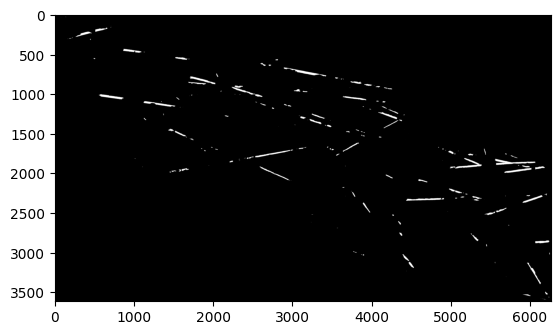

In [6]:
plt.imshow(prediction)
plt.gray()
plt.show()

In [7]:
#Predict with resample the image at once via rasterio

tt = Timer()
tt.start()

img,profile =Analyzer.IO.load_orthomosaic_with_resampling(image_dir+img_name, config)

prediction=Analyzer.Pred.predict(img, model, config)           
                
#profile.update(dtype=rasterio.float32, count=1) 
#height, width = prediction.shape
#profile['width']=width
#profile['height']=height

#with rasterio.open(os.path.join(stem_map_dir, f'predic_{file_name}_resampled.tiff'), 'w', **profile) as dst:
#            dst.write(prediction.astype(rasterio.float32), 1)
Analyzer.IO.export_stem_map(prediction, profile, pred_dir, file_name+'_resampled')

tt.stop()    


#######################################################
Prediction of semantic stem map
24  tiles analyzed
Elapsed time: 1.9958 seconds
#######################################################

Elapsed time: 2.9769 seconds


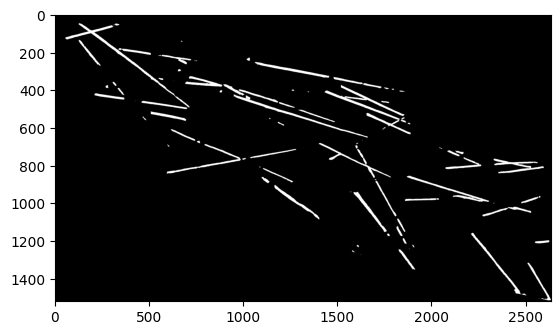

In [8]:
plt.imshow(prediction)
plt.gray()
plt.show()

In [9]:
#Predict with resampling per tile

tt = Timer()
tt.start()

img, profile =Analyzer.IO.load_orthomosaic(image_dir+img_name, config)
 
prediction, profile=Analyzer.Pred.predict_with_resampling_per_tile(img, profile, model,config)   

Analyzer.IO.export_stem_map(prediction, profile, pred_dir, file_name+'_resampled_per_tile')        

tt.stop()    


#######################################################
Prediction of the semantic stem map
Resampling tiles while analyzing
24  tiles analyzed
Elapsed time: 2.8150 seconds
#######################################################

Elapsed time: 3.2651 seconds


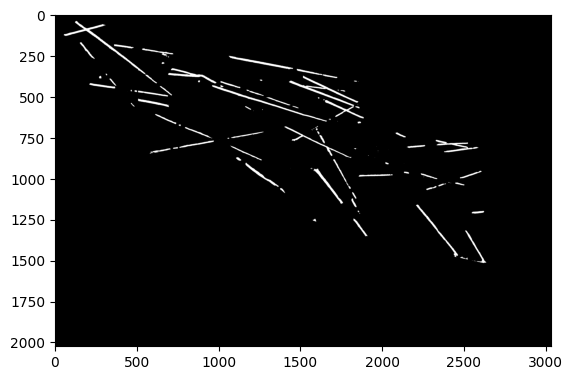

In [10]:
plt.imshow(prediction)
plt.gray()
plt.show()